In [4]:
# !pip install imbalanced-ensemble
# !pip install --upgrade imbalanced-ensemble

In [32]:
import imbens

# Import utilities
import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd

import numpy as np
from collections import Counter
from imbens.datasets import make_imbalance
from imbens.ensemble.base import sort_dict_by_key

from imbens.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier


In [56]:
# 加载数据
data = pd.read_csv("E:\竞赛\服创赛-A08\data\process_data.csv")
data.head()

# 定义特征和目标变量
X = data.drop(columns=[#'个人编码', 
                              'RES']) 
y = data['RES']

In [34]:
# train valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=123
)

In [43]:
rf_model = BalancedRandomForestClassifier(n_estimators=100,random_state=42,sampling_strategy="all",
    replacement=True,
    bootstrap=False,)
rf_model.fit(X_train, y_train)
fitted_ensembles = {'SPE': rf_model}

In [38]:
lgb_model = LGBMClassifier(random_state=42, 
                           is_unbalance=True,
                           n_estimators=100)
lgb_model.fit(X_train, y_train)
fitted_ensembles = {'SPE': lgb_model}

[LightGBM] [Info] Number of positive: 595, number of negative: 11405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3010
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049583 -> initscore=-2.953246
[LightGBM] [Info] Start training from score -2.953246


In [28]:
# Initialize and train an SPE classifier
clf = imbens.ensemble.SelfPacedEnsembleClassifier(n_estimators=100,random_state=123).fit(
    X_train, y_train
)

# Store the fitted SelfPacedEnsembleClassifier
fitted_ensembles = {'SPE': clf}

In [44]:
# Initialize visualizer
visualizer = imbens.visualizer.ImbalancedEnsembleVisualizer(
    eval_datasets={
        'training': (X_train, y_train),
        'validation': (X_valid, y_valid),
    },
)

# Fit visualizer
visualizer.fit(fitted_ensembles)

Visualizer evaluating model SPE on dataset  training  :: 100%|██████████████████████| 100/100 [00:00<00:00, 111.57it/s]
Visualizer evaluating model SPE on dataset validation :: 100%|██████████████████████| 100/100 [00:00<00:00, 204.47it/s]


Visualizer computing confusion matrices.. Finished!


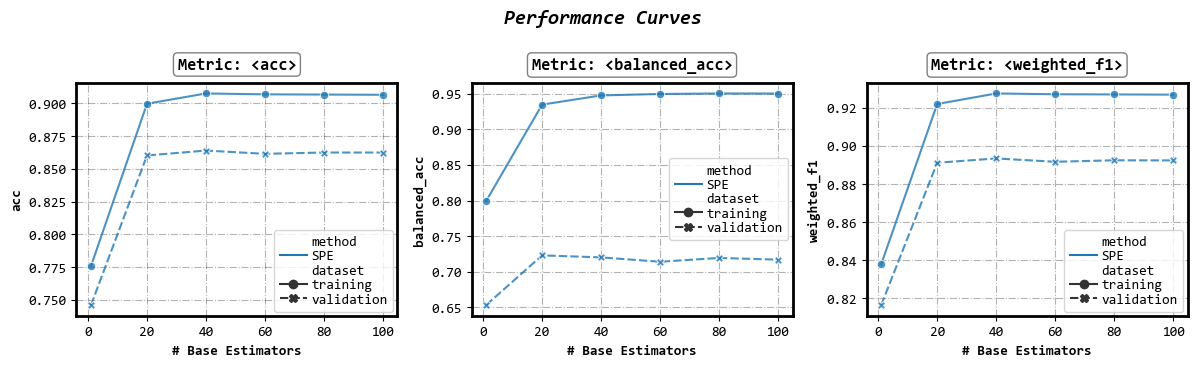

In [45]:
fig, axes = visualizer.performance_lineplot()

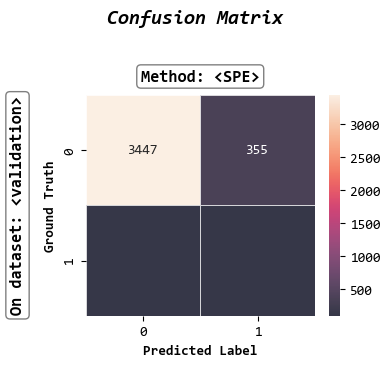

In [31]:
fig, axes = visualizer.confusion_matrix_heatmap(
    on_datasets=['validation'],  # only on validation set
    sup_title=True,
)

In [57]:
# 定义一个函数，用于单独训练和返回模型
def get_specific_ratio_model(X, y, specific_ratio):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    final_model = None

    for train_index, test_index in skf.split(X, y):
        # 分割数据
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # 分离多数和少数类
        X_train_majority = X_train[y_train == 0]
        X_train_minority = X_train[y_train == 1]

        # 执行欠采样
        majority_sample_size = int(len(X_train_minority) * specific_ratio)
        X_train_majority_downsampled = resample(X_train_majority, 
                                                replace=False,
                                                n_samples=majority_sample_size,
                                                random_state=123)
        y_train_majority_downsampled = y_train.loc[X_train_majority_downsampled.index]

        # 合并数据
        X_train_downsampled = pd.concat([X_train_majority_downsampled, X_train_minority])
        y_train_downsampled = pd.concat([y_train_majority_downsampled, y_train[y_train == 1]])

        # 创建并训练模型
        # RF_1 = RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1,max_depth=20)
        # RF_1.fit(X_train, y_train)
        rf_model = BalancedRandomForestClassifier(n_estimators=100,random_state=42,
                                                  # sampling_strategy="all",
                                                  # replacement=True,
                                                  # bootstrap=False,
                                                 )
        rf_model.fit(X_train, y_train)

        # 更新最后一个模型
        final_model = rf_model

        # 设置阈值为0.6
        threshold = 0.5
        
        # 以概率形式获取预测结果
        y_probs = rf_model.predict_proba(X_test)[:, 1] # 获取正类的概率
        
        # 应用阈值
        y_pred_thresh = np.where(y_probs > threshold, 1, 0)
        # 生成分类报告
        classification_report_06 = classification_report(y_test, y_pred_thresh)
        
        print(classification_report_06)

    return final_model,X_test,y_test

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
# 获取比例为n:1的模型(提高比例会略微提高AUC，但不显著)
specific_ratio = 6
final_model,X_test,y_test = get_specific_ratio_model(X, y, specific_ratio)


              precision    recall  f1-score   support

           0       0.99      0.83      0.90      3042
           1       0.20      0.83      0.33       158

    accuracy                           0.83      3200
   macro avg       0.60      0.83      0.61      3200
weighted avg       0.95      0.83      0.87      3200

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      3042
           1       0.20      0.87      0.33       158

    accuracy                           0.83      3200
   macro avg       0.60      0.85      0.62      3200
weighted avg       0.95      0.83      0.87      3200

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3041
           1       0.21      0.83      0.34       159

    accuracy                           0.84      3200
   macro avg       0.60      0.83      0.62      3200
weighted avg       0.95      0.84      0.88      3200

              preci